In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
import seaborn as sns
import scienceplots

import candel
from candel import plot_corner_from_hdf5
from utils import * 


%matplotlib inline
%load_ext autoreload
%autoreload 2


COLS = ["#87193d", "#1e42b9", "#d42a29", "#05dd6b", "#ee35d5"]

In [2]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
config = candel.load_config(config_path, )
root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "S8")

## Posterior summary

In [3]:
fname = "precomputed_los_Carrick2015_CF4_W1_MNR_linear_from_beta_stochastic_eta_sampled.hdf5"

fname = join(root, fname)

with File(fname, "r") as f:
    grp = f["samples"]
    print(f"keys: {list(grp.keys())}")
    keys = ["beta", ]

    samples = {key: grp[key][...] for key in keys}

keys_read = ["beta"]
# keys_read = ['M_dipole_b', 'M_dipole_ell', 'M_dipole_mag']
# keys_read = ['Vext_b', 'Vext_ell', 'Vext_mag']

for key in keys_read:
    low, med, high = np.percentile(samples[key], [16, 50, 84])
    low = med - low
    high = high - med
    print(f"{key}: {med:.3f} +{high:.3f} -{low:.3f}")


# a_TFR_dipole_mag: 0.073 +0.024 -0.026

keys: ['R_dist_emp', 'Vext', 'Vext_b', 'Vext_ell', 'Vext_mag', 'a_TFR', 'b1', 'b_TFR', 'beta', 'c_TFR', 'eta_latent', 'eta_prior_mean', 'eta_prior_std', 'n_dist_emp', 'p_dist_emp', 'sigma_int', 'sigma_v']
beta: 0.451 +0.013 -0.012


### Playground

precomputed_los_Carrick2015_CF4_W1_MNR_linear_from_beta_stochastic_eta_sampled.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, n_dist_emp, p_dist_emp, sigma_int, sigma_v
precomputed_los_Carrick2015_CF4_i_MNR_linear_from_beta_stochastic_eta_sampled.hdf5: R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, a_TFR, b1, b_TFR, beta, c_TFR, eta_latent, eta_prior_mean, eta_prior_std, n_dist_emp, p_dist_emp, sigma_int, sigma_v


precomputed_los_Carrick2015_PantheonPlus_MNR_linear_from_beta_stochastic.hdf5: M, R_dist_emp, Vext, Vext_b, Vext_ell, Vext_mag, b1, beta, n_dist_emp, p_dist_emp, r_latent, sigma_int, sigma_v
Removed no burn in
Removed no burn in
Removed no burn in


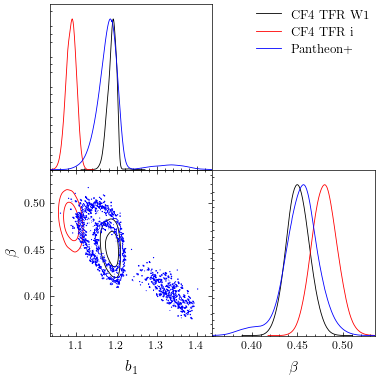

In [6]:
fnames = [
    "precomputed_los_Carrick2015_CF4_W1_MNR_linear_from_beta_stochastic_eta_sampled.hdf5",
    "precomputed_los_Carrick2015_CF4_i_MNR_linear_from_beta_stochastic_eta_sampled.hdf5",
    "precomputed_los_Carrick2015_PantheonPlus_MNR_linear_from_beta_stochastic.hdf5",
    ]

labels = [
    "CF4 TFR W1",
    "CF4 TFR i",
    "Pantheon+"
    ]

fnames = [join(root, f) for f in fnames]

plot_corner_from_hdf5(
    fnames,
    labels=labels,
    # fontsize=18,
    filled=False,
    keys=["b1", "beta"],
    # filename="C15_full_posterior.pdf",
    )

In [12]:
beta2cosmo = candel.cosmo.Beta2Cosmology()

runs = [
    ("precomputed_los_Carrick2015_CF4_W1_MNR_linear_from_beta_stochastic_eta_sampled.hdf5", "CF4 TFR W1"),
    ("precomputed_los_Carrick2015_CF4_i_MNR_linear_from_beta_stochastic_eta_sampled.hdf5", "CF4 TFR i"),
    ("precomputed_los_Carrick2015_PantheonPlus_MNR_linear_from_beta_stochastic.hdf5", "Pantheon+"),
    ("precomputed_los_Carrick2015_SDSS_FP_noMNR_linear_from_beta_stochastic.hdf5", "SDSS FP"),
    ("precomputed_los_Carrick2015_6dF_FP_noMNR_linear_from_beta_stochastic.hdf5", "6dF FP")
]

runs = replace_token_in_paths(runs, "linear_from_beta_stochastic", "linear")

filenames = [f[0] for f in runs]
labels = [f[1] for f in runs]
fnames = [join(root, f) for f in filenames]

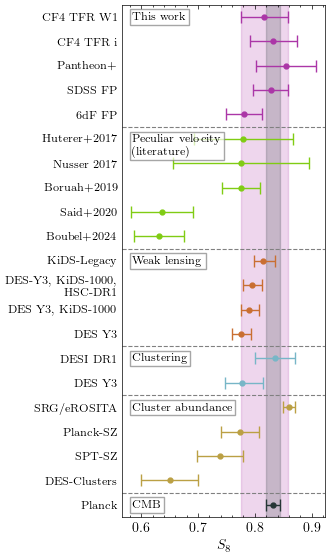

In [15]:

# --- This work ---
S8_list   = compute_S8_all(fnames, beta2cosmo)
this_names = labels
means_this = [np.mean(x) for x in S8_list]
errs_this  = [(np.percentile(x, 16), np.percentile(x, 84)) for x in S8_list]
lower_this = [a for a, _ in errs_this]
upper_this = [b for _, b in errs_this]

# --- Literature blocks ---
lit_blocks = {
    "pv": [
        ("Huterer+2017", 0.780, 0.087),
        ("Nusser 2017",  0.776, 0.120),
        ("Boruah+2019",  0.776, 0.033),
        ("Said+2020",    0.637, 0.054),
        ("Boubel+2024",  0.632, 0.044),
    ],
    "wl": [
        ("KiDS-Legacy",              0.814, (0.016, 0.021)),
        ("DES-Y3, KiDS-1000,\nHSC-DR1", 0.795, (0.015, 0.017)),
        ("DES Y3, KiDS-1000",        0.790, (0.014, 0.018)),
        ("DES Y3",                   0.776, 0.017),
    ],
    "clustering": [
        ("DESI DR1", 0.836, 0.035),
        ("DES Y3",   0.778, (0.031, 0.037)),
    ],
    "clusters": [
        ("SRG/eROSITA",  0.86,  0.01),
        ("Planck-SZ",    0.774, 0.034),
        ("SPT-SZ",       0.739, 0.041),
        ("DES-Clusters", 0.650, 0.050),
    ],
    "cmb": [
        ("Planck", 0.832, 0.013),
    ],
}

# Flatten
lit_names, lit_means, lit_errs = [], [], []
for group in ["pv", "wl", "clustering", "clusters", "cmb"]:
    for name, m, s in lit_blocks[group]:
        lit_names.append(name)
        lit_means.append(m)
        lit_errs.append(s)

# Convert symmetric/asymmetric errors to bounds
def _to_bounds(means, errs):
    lows, ups = [], []
    for m, e in zip(means, errs):
        if isinstance(e, tuple):
            lows.append(m - e[0]); ups.append(m + e[1])
        else:
            lows.append(m - e);    ups.append(m + e)
    return lows, ups

lower_lit, upper_lit = _to_bounds(lit_means, lit_errs)

# Combine
names = this_names + lit_names
means = means_this + lit_means
lower = lower_this + lower_lit
upper = upper_this + upper_lit
err_lo = np.array(means) - np.array(lower)
err_hi = np.array(upper) - np.array(means)

# --- Block sizes for dividers ---
n_this = len(this_names)
n_pv   = len(lit_blocks["pv"])
n_wl   = len(lit_blocks["wl"])
n_cl   = len(lit_blocks["clustering"])
n_cls  = len(lit_blocks["clusters"])
n_cmb  = len(lit_blocks["cmb"])
block_sizes  = [n_this, n_pv, n_wl, n_cl, n_cls, n_cmb]
block_labels = ["This work", "Peculiar velocity\n(literature)", "Weak lensing",
                "Clustering", "Cluster abundance", "CMB"]

# Colors per block
# tab = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]
tab = ["#263636", "#BBA044", "#77B6C7", "#C96F32", "#80CC14", "#AB36A7"][::-1]
colors = (
    [tab[0]] * n_this +
    [tab[1]] * n_pv +
    [tab[2]] * n_wl +
    [tab[3]] * n_cl +
    [tab[4]] * n_cls +
    [tab[5]] * n_cmb
)

# --- Plot ---
with plt.style.context("science"):  # requires SciencePlots (or use 'default')
    fig, ax = plt.subplots(figsize=(3.5, 2.625 * 2.2))

    # Set y-limits early so the spans visually cover the full panel
    ax.set_ylim(0.5, len(names) + 0.5)

    # -------- Full-height shaded 1σ bands --------
    # (1) First "This work" entry (index 0)
    if len(means_this) > 0:
        this_mu0 = means_this[0]
        this_lo0 = lower_this[0]
        this_hi0 = upper_this[0]
        ax.axvspan(this_lo0, this_hi0, ymin=0, ymax=1, color=colors[0], alpha=0.2, zorder=0)

    # (2) Planck (CMB)
    # Get Planck mean and error from the lit_blocks["cmb"] entry
    planck_name, planck_m, planck_s = lit_blocks["cmb"][0]
    if isinstance(planck_s, tuple):
        planck_lo, planck_hi = planck_m - planck_s[0], planck_m + planck_s[1]
    else:
        planck_lo, planck_hi = planck_m - planck_s, planck_m + planck_s
    ax.axvspan(planck_lo, planck_hi, ymin=0, ymax=1, color=colors[-1], alpha=0.2, zorder=0)
    # ---------------------------------------------

    # Points with horizontal error bars
    for i, (name, mu, elo, ehi, color) in enumerate(zip(names, means, err_lo, err_hi, colors), start=1):
        ax.errorbar(mu, i, xerr=[[elo],[ehi]], fmt="o", color=color, capsize=4, ms=3.5)

    # Dividers
    cumulative = np.cumsum(block_sizes)
    for y in cumulative[:-1] + 0.5:
        ax.axhline(y, color="0.5", linestyle="--", lw=0.8)

    # Group labels
    starts = np.concatenate(([0], cumulative[:-1]))
    tform = ax.get_yaxis_transform()
    for start, size, label in zip(starts, block_sizes, block_labels):
        if size == 0:
            continue
        y = start + 0.8
        ax.text(0.05, y, label, transform=tform,
                ha="left", va="top", fontsize="small", weight="bold",
                bbox=dict(facecolor="white", edgecolor="0.5", alpha=0.7, pad=2.0))

    ax.set_yticks(range(1, len(names) + 1), names, fontsize="small")
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_xlabel(r"$S_8$")
    ax.invert_yaxis()
    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/S8_comparison.pdf", dpi=450, bbox_inches="tight")
    plt.show()

### Table of b1 and beta values

In [10]:
runs = [
    ("precomputed_los_Carrick2015_CF4_W1_MNR_linear_from_beta_stochastic_eta_sampled.hdf5", "CF4 TFR W1"),
    ("precomputed_los_Carrick2015_CF4_i_MNR_linear_from_beta_stochastic_eta_sampled.hdf5", "CF4 TFR i"),
    ("precomputed_los_Carrick2015_PantheonPlus_MNR_linear_from_beta_stochastic.hdf5", "Pantheon+"),
    ("precomputed_los_Carrick2015_SDSS_FP_noMNR_linear_from_beta_stochastic.hdf5", "SDSS FP"),
    ("precomputed_los_Carrick2015_6dF_FP_noMNR_linear_from_beta_stochastic.hdf5", "6dF FP")
]


runs = replace_token_in_paths(runs, "linear_from_beta_stochastic", "linear")

filenames = [f[0] for f in runs]
labels = [f[1] for f in runs]
fnames = [join(root, f) for f in filenames]

In [11]:
b1_list   = get_key_all(fnames, "b1")
beta_list = get_key_all(fnames, "beta")

for i, (name, b1_samples, beta_samples) in enumerate(zip(labels, b1_list, beta_list)):
    b1mean, b1std = np.mean(b1_samples), np.std(b1_samples)
    print(f"{name}: b1 = {b1mean:.3f} ± {b1std:.3f} | beta = {np.mean(beta_samples):.3f} ± {np.std(beta_samples):.3f}")


CF4 TFR W1: b1 = 1.192 ± 0.012 | beta = 0.475 ± 0.019
CF4 TFR i: b1 = 1.088 ± 0.013 | beta = 0.485 ± 0.019
Pantheon+: b1 = 1.362 ± 0.054 | beta = 0.500 ± 0.029
SDSS FP: b1 = 1.412 ± 0.007 | beta = 0.482 ± 0.006
6dF FP: b1 = 1.539 ± 0.005 | beta = 0.452 ± 0.010


CF4 TFR W1: 0.780 ± 0.034 | 1.404
CF4 TFR i: 0.825 ± 0.036 | 0.228
Pantheon+: 0.784 ± 0.043 | 1.053
SDSS FP: 0.804 ± 0.031 | 0.817
6dF FP: 0.704 ± 0.029 | 3.820


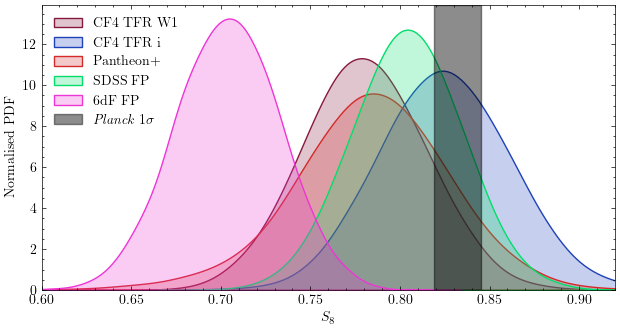

In [48]:
import posterior_agreement

S8_list = compute_S8_all(fnames, beta2cosmo)

bw = 0.25

planck_mean, planck_std = 0.832, 0.013
rng = np.random.default_rng(seed=42)
planck_samples = rng.normal(loc=planck_mean, scale=planck_std, size=100_000)

with plt.style.context("science"):
    plt.figure(figsize=(6.4, 3.5))

    # Plot KDEs for "this work" datasets
    i = 0
    for S8, label in zip(S8_list, labels):
        agreement_1d = posterior_agreement.compute_agreement((planck_samples, S8)).sigma
        print(f"{label}: {np.mean(S8):.3f} ± {np.std(S8):.3f} | {agreement_1d:.3f}")
        sns.kdeplot(S8, label=label, fill=True, color=COLS[i], bw_method=bw)
        i += 1

    # Replace Planck KDE with shaded 1σ band
    plt.axvspan(planck_mean - planck_std, planck_mean + planck_std,
                color="k", alpha=0.45, label=r"\textit{Planck} $1\sigma$")

    plt.xlim(0.6, 0.92)
    plt.xlabel(r"$S_8$")
    plt.ylabel("Normalised PDF")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/S8_posterior.pdf", bbox_inches="tight", dpi=450)
    plt.show()